# COGS 181 Final Project on mask no mask dataset


### Yushan Wang A14459085
### Jiemin Tang A13948547

### Import package

In [1]:
from __future__ import print_function
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from random import shuffle
from random import randint

# It should print "Using TensorFlow backend"

Using TensorFlow backend.


In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array

### Helper function

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(20,20))
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)

### Initialize path directories for dataset

In [4]:
# paths for thw two dataset folders
mask = r'dataset/mask'
no_mask = r'dataset/no_mask'

### Load and Store images

In [5]:
# store images from the dataset
images = []
for file in list(os.listdir(mask)):
    images.append(cv2.imread(mask+'/'+file))
    
for file in list(os.listdir(no_mask)):
    images.append(cv2.imread(no_mask+'/'+file)) 
    
images = np.array(images)

### One-hot encoding for mask/no-mask

In [6]:
# store labels (mask = 1,0 and  no mask = 0,1)
n_mask = len(list(os.listdir(mask)))
n_no_mask = len(list(os.listdir(no_mask)))
labels = np.zeros(( n_mask  + n_no_mask, 2  ))
labels[:n_mask,0] = 1
labels[n_mask:,1] = 1
print('y shape',labels.shape)   #(2767, 2)
print('x shape',images.shape)   #(2767, 160, 160, 3)

y shape (2767, 2)
x shape (2767, 160, 160, 3)


### shuffle and split data

In [7]:
data_size = labels.shape[0]
index = list(range(data_size))
shuffle(index)
index = np.array(index)
images =   images[index]
labels =   labels[index,:]
x_train =  images[:int(0.8*data_size)]
y_train =  labels[:int(0.8*data_size),:] 
x_test =   images[int(0.8*data_size):]
y_test =   labels[int(0.8*data_size):,:]

### Preview data
#### Show random image with corresponding label

Without Mask


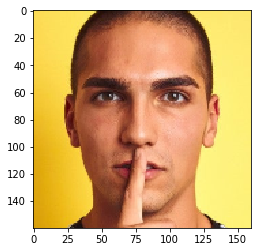

In [8]:
rand_int = randint(0, len(x_test))
plt.imshow(x_test[rand_int][:,:,::-1])
print((np.array(['With Mask','Without Mask'])[y_test[rand_int] == 1])[0])

### initialize model parameters

In [9]:
img_rows, img_cols = images.shape[1], images.shape[2]
input_shape = (images.shape[1], images.shape[2], images.shape[3])
batch_size = 1
num_classes = 2

### Create Model

In [10]:
baseModel = VGG16(weights="imagenet", include_top=False,input_tensor=Input(shape=(160, 160, 3)))

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(num_classes, activation="softmax")(headModel)


model = Model(inputs=baseModel.input, outputs=headModel)

In [11]:
for layer in baseModel.layers:
    layer.trainable = False

opt = Adam(lr=1e-3, decay= 1e-3 / 20)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 160, 160, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 160, 160, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 80, 80, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 80, 80, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 80, 80, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 40, 40, 128)       0     

In [12]:
#trainAug = ImageDataGenerator(rotation_range=15, fill_mode="nearest")
H = model.fit(
    x_train, y_train,
    batch_size=batch_size,
          epochs=10,
          verbose=1,
          validation_data=(x_test, y_test))

Epoch 1/10
2213/2213 [==============================] - 108s 49ms/step - loss: 0.5471 - accuracy: 0.9372 - val_loss: 0.0958 - val_accuracy: 0.9783
Epoch 2/10
2213/2213 [==============================] - 112s 51ms/step - loss: 0.1442 - accuracy: 0.9684 - val_loss: 0.1011 - val_accuracy: 0.9747
Epoch 3/10
2213/2213 [==============================] - 112s 51ms/step - loss: 0.0919 - accuracy: 0.9774 - val_loss: 0.0682 - val_accuracy: 0.9819
Epoch 4/10
2213/2213 [==============================] - 112s 51ms/step - loss: 0.0679 - accuracy: 0.9828 - val_loss: 0.0763 - val_accuracy: 0.9838
Epoch 5/10
2213/2213 [==============================] - 110s 50ms/step - loss: 0.0783 - accuracy: 0.9819 - val_loss: 0.0832 - val_accuracy: 0.9856
Epoch 6/10
2213/2213 [==============================] - 111s 50ms/step - loss: 0.0443 - accuracy: 0.9878 - val_loss: 0.0968 - val_accuracy: 0.9874
Epoch 7/10
2213/2213 [==============================] - 112s 51ms/step - loss: 0.0440 - accuracy: 0.9896 - val_loss: 0

### Evaluate model

In [13]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11452584713697433
Test accuracy: 0.9855595827102661


### Test model

['With Mask']


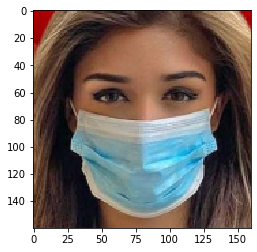

In [14]:
rand_int = randint(0, 552)
m = model.predict(x_test[rand_int].reshape(-1,160,160,3)) == model.predict(x_test[rand_int].reshape(-1,160,160,3)).max()
plt.imshow(x_test[rand_int][:,:,::-1])
print(np.array(['With Mask','Without Mask'])[m[0]])

### Save the model

In [15]:
# save the model
modelsave_name = 'vgg_face_mask.h5'
model.save(modelsave_name)

In [16]:
ap = argparse.ArgumentParser()
ap.add_argument("-f", "--face", type=str,
    default="face_detector",
    help="path to face detector model directory")
ap.add_argument("-c", "--confidence", type=float, default=0.5,
    help="minimum probability to filter weak detections")
args = vars(ap.parse_args())

In [17]:
prototxtPath = os.path.sep.join(["./face_detector/deploy.prototxt"])
weightsPath = os.path.sep.join(["./face_detector/res10_300x300_ssd_iter_140000.caffemodel"])
faceNet = cv2.dnn.readNet(prototxtPath, weightsPath)

In [ ]:
mask_model = model
cap = cv2.VideoCapture(0)

video_capture = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frames = video_capture.read()
    #print(frames)
    
    (h, w) = frames.shape[:2]
    blob = cv2.dnn.blobFromImage(frames, 1.0, (300, 300),(104.0, 177.0, 123.0))
    faceNet.setInput(blob)
    detections = faceNet.forward()

    for i in range(0, detections.shape[2]):	
        confidence = detections[0, 0, i, 2]
        
        
        if confidence > args["confidence"]:
            box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
            (startX, startY, endX, endY) = box.astype("int")
            
            (startX, startY) = (max(0, startX), max(0, startY))
            (endX, endY) = (min(w - 1, endX), min(h - 1, endY))
            
            face = frames[startY:endY, startX:endX]
            face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            face = cv2.resize(face, (160, 160))
            face = img_to_array(face)
            face = preprocess_input(face)
            face = np.expand_dims(face, axis=0)
            #(startX, startY, endX, endY)
            #cv2.rectangle(frames, (startX, startY), (startX+endX, startY+endY), (0, 255, 0), 2)
            
            #face = frames[y:y+h, x:x+w]
            #face = cv2.cvtColor(face, cv2.COLOR_BGR2RGB)
            #face = cv2.resize(face, (160, 160))
            #print(face.shape)
            
            model_prediction = mask_model.predict(face.reshape(-1,160,160,3)) == mask_model.predict(face.reshape(-1,160,160,3)).max()
            my_result = np.sum(mask_model.predict(face.reshape(-1,160,160,3)), axis = 0)
            if my_result[0] >= my_result[1]:
                display_string = 'With Mask'
                color = (36,255,12)
                cv2.rectangle(frames, (startX, startY), (endX, endY), color, 2)
            else:
                display_string = 'Without Mask'
                color = (36,0,255)
                cv2.rectangle(frames, (startX, startY), (endX, endY), color, 2)
            print(display_string)
            cv2.putText(frames, display_string, (startX, startY-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (36,255,12), 1)
            
    # Display the resulting frame
    cv2.imshow('Video', frames)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

video_capture.release()
cv2.destroyAllWindows()

Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
Without Mask
With Mask
With Mask
With Mask
With Mask
With Mask
With Mask
With Mask
With Mask
With Mask
With Mask
With Mask
With Mask
With Mask
With Mask
With Mask
With Mask
With Mas